Suggested dimensions for U: 20
Suggested dimensions for Y: 1
Shape of U_p: (10, 981)
Rank of U_p: 10
Condition number of U_p: 1.063015124675322
Shape of U_f: (10, 981)
Rank of U_f: 10
Condition number of U_f: 1.0639099475956695
Shape of Y_p: (10, 981)
Rank of Y_p: 10
Condition number of Y_p: 2829.097075695301
Shape of Y_f: (10, 981)
Rank of Y_f: 10
Condition number of Y_f: 2738.1281117864123
Shape of A: (30, 981)
Rank of A: 22
Condition number of A: 1.058115624096746e+17
Shape of M: (10, 30)
Rank of M: 10
Condition number of M: 3868.837255100548
Shape of G: (10, 10)
Rank of G: 10
Condition number of G: 10331.7861604486


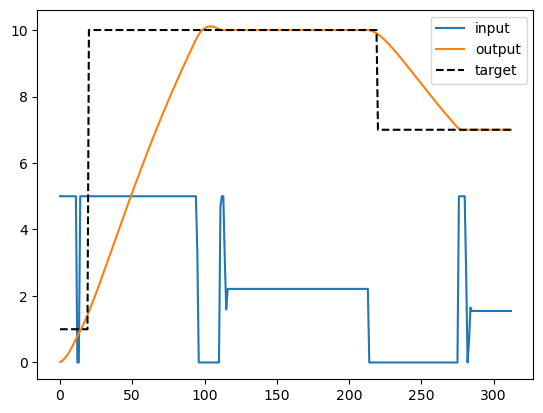

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deepc import Controller, DiscreteLTI, linear_chirp, data_quality

# Define a system
system = DiscreteLTI(
    A=[[1.9154297228892199, -0.9159698592594919], [1.0, 0.0]],
    B=[[0.0024407501942859677], [0.0]],
    C=[[1, 0]],
    D=[[0]],
    x_ini=[1, 1],
)

# Gather offline data
N = 1000
# by defining a input sequence
u_d = linear_chirp(0, N / 2, N)
# and applying it to the system
y_d = system.apply_multiple(u_d)

# Define how many steps the controller should look back
# to grasp the current state of the system
T_ini = 13

# Define how many steps the controller should look forward
r_len = 7

data_quality(u_d, y_d, T_ini, r_len)

# Define the controller
controller = Controller(u_d, y_d, T_ini, r_len, input_constrain_fkt=lambda u: np.clip(u, 0, 5))

# Reset the system
# to sepereate the offline data from the online data
system.set_state([0, 0])  # This is intentionally not the same state as x_ini

# Warm up the controller
while not controller.is_initialized():
    u = [0]
    y = system.apply(u)
    controller.update(u, y)

# Simulate the system
u_online = []
y_online = []
r_online = [[0]] * 20 + [[10]] * 200 + [[7]] * 100
for i in range(len(r_online) - r_len):
    r = r_online[i: i + r_len]
    print(r)
    u = controller.apply(r)[0]
    y = system.apply(u)
    controller.update(u, y)
    u_online.append(u)
    y_online.append(y)
    r_online.append(r)

# Plot the results
plt.plot(u_online, label="input")
plt.plot(y_online, label="output")
plt.plot(r_online[:len(y_online)], label="target", color="black", linestyle="--")
plt.legend()